<a href="https://colab.research.google.com/github/hoangnuthuphuong/final_project-a/blob/main/CanDetect_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**CHUẨN BỊ**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Xác định đường dẫn đến file ZIP
zip_path = '/content/drive/MyDrive/DOANTOTNGHIEP/DATA_FULL.zip'

# Giải nén tập tin vào thư mục /content/dataset
!unzip -q {zip_path} -d /content/dataset

##**Chuẩn bị và tiền xử lý dữ liệu**

In [ ]:
import tensorflow as tf
import numpy as np

# Define parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE # Use tf.data.AUTOTUNE for BUFFER_SIZE as it's common for prefetching
data_dir = '/content/dataset/DATA_FULL/CNN'
CLASS_NAMES = ['NOT_11201366', 'OK_11201366'] # Corrected class names based on the error message
seed = 42

# Load initial training and validation datasets
print(f"Loading data from: {data_dir}")
train_ds_initial = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

print("Initial training and validation datasets loaded.")

# Determine the number of batches in val_test_ds and split it into final validation and test datasets
val_batches = tf.data.experimental.cardinality(val_test_ds).numpy() // 2
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)
print(f"Validation and test datasets split. Validation batches: {val_batches}, Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

# Apply data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

augmented_train_ds = train_ds_initial.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
print("Data augmentation applied to the training dataset.")

# Apply preprocessing (normalization) to all datasets
preprocess_input = tf.keras.layers.Rescaling(1./255.0) # Scale pixel values to [0, 1]

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = augmented_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
print("Preprocessing (normalization) applied to all datasets.")

# Optimize dataset performance by caching and prefetching
train_ds = train_ds.cache().prefetch(buffer_size=BUFFER_SIZE)
val_ds = val_ds.cache().prefetch(buffer_size=BUFFER_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=BUFFER_SIZE)
print("Datasets optimized with caching and prefetching.")

Loading data from: /content/dataset/DATA_FULL/CNN
Found 2732 files belonging to 2 classes.
Using 2186 files for training.
Found 2732 files belonging to 2 classes.
Using 546 files for validation.
Initial training and validation datasets loaded.
Validation and test datasets split. Validation batches: 9, Test batches: 9
Data augmentation applied to the training dataset.
Preprocessing (normalization) applied to all datasets.
Datasets optimized with caching and prefetching.


#**HUẤN LUYỆN MÔ HÌNH**

Tải mô hình EfficientNetB0 đã được đào tạo trước , sửa đổi lớp cuối cùng của nó để phù hợp với phân loại nhị phân (OK/NOT), và biên dịch mô hình với trình tối ưu hóa Adam và hàm mất mát Binary Cross-Entropy).

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# 1. Instantiate the EfficientNetB0 base model
# Load a pre-trained EfficientNetB0 model without its top classification layer
base_model = EfficientNetB0(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# 2. Add custom layers on top of the base model
# Global Average Pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Dense output layer for binary classification with sigmoid activation
predictions = Dense(1, activation='sigmoid')(x)

# 3. Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# 4. Recompile the model after unfreezing, with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.00001), # Significantly lower learning rate for fine-tuning
    loss=BinaryCrossentropy(from_logits=False), # from_logits=False because we use sigmoid activation
    metrics=['accuracy']
)

print("EfficientNet model defined, unfrozen, and recompiled successfully for fine-tuning.")
model.summary()

EfficientNet model defined, unfrozen, and recompiled successfully for fine-tuning.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_4[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Define the number of training epochs
epochs = 50

# 2. Create an EarlyStopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10, # Increased patience for fine-tuning
#     restore_best_weights=True,
#     verbose=1
# )

# 3. Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_efficientnet_model.weights.h5', # Save only weights
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# 4. Train the model
print(f"Starting model fine-tuning for {epochs} epochs...")
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[model_checkpoint] # Removed early_stopping from callbacks
)

# 5. Store the training history (already done above)

print("Model fine-tuning complete. Training history stored.")

Starting model fine-tuning for 50 epochs...
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7535 - loss: 0.5192
Epoch 1: val_loss improved from inf to 0.68737, saving model to best_efficientnet_model.weights.h5
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7538 - loss: 0.5190 - val_accuracy: 0.4688 - val_loss: 0.6874
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7927 - loss: 0.4729
Epoch 2: val_loss did not improve from 0.68737
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7926 - loss: 0.4728 - val_accuracy: 0.4688 - val_loss: 0.7227
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8071 - loss: 0.4372
Epoch 3: val_loss did not improve from 0.68737
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.8071 - loss: 0.4371 - val_accuracy: 0.4688 - val_loss: 0.7076
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8153 - loss: 0.4127
Epoch 4: val_loss did not improve from 0.68737
69/69 ━━━━━━━━━━━━━

Kết quả kiểm tra trên tập test



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# 1. Load the best saved weights
print("Loading best model weights...")
model.load_weights('best_efficientnet_model.weights.h5')
print("Best model weights loaded.")

# 2. Evaluate the model on the test_ds dataset
print("Evaluating model on test dataset...")
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 3. Make predictions on the test_ds dataset
print("Making predictions on test dataset...")
predictions = model.predict(test_ds)

# 4. Convert predicted probabilities into binary class labels
predicted_labels = (predictions > 0.5).astype(int)

# 5. Extract the true labels from the test_ds dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# 7. Calculate and print the test accuracy, precision, recall, and F1-score
overall_accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"\nOverall Test Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 8. Calculate and print the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

Loading best model weights...
Best model weights loaded.
Evaluating model on test dataset...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7673 - loss: 0.4557
Test Loss: 0.4426
Test Accuracy: 0.8062
Making predictions on test dataset...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Overall Test Metrics:
Accuracy: 0.8062
Precision: 0.7267
Recall: 0.9766
F1-Score: 0.8333

Confusion Matrix:
[[ 83  47]
 [  3 125]]


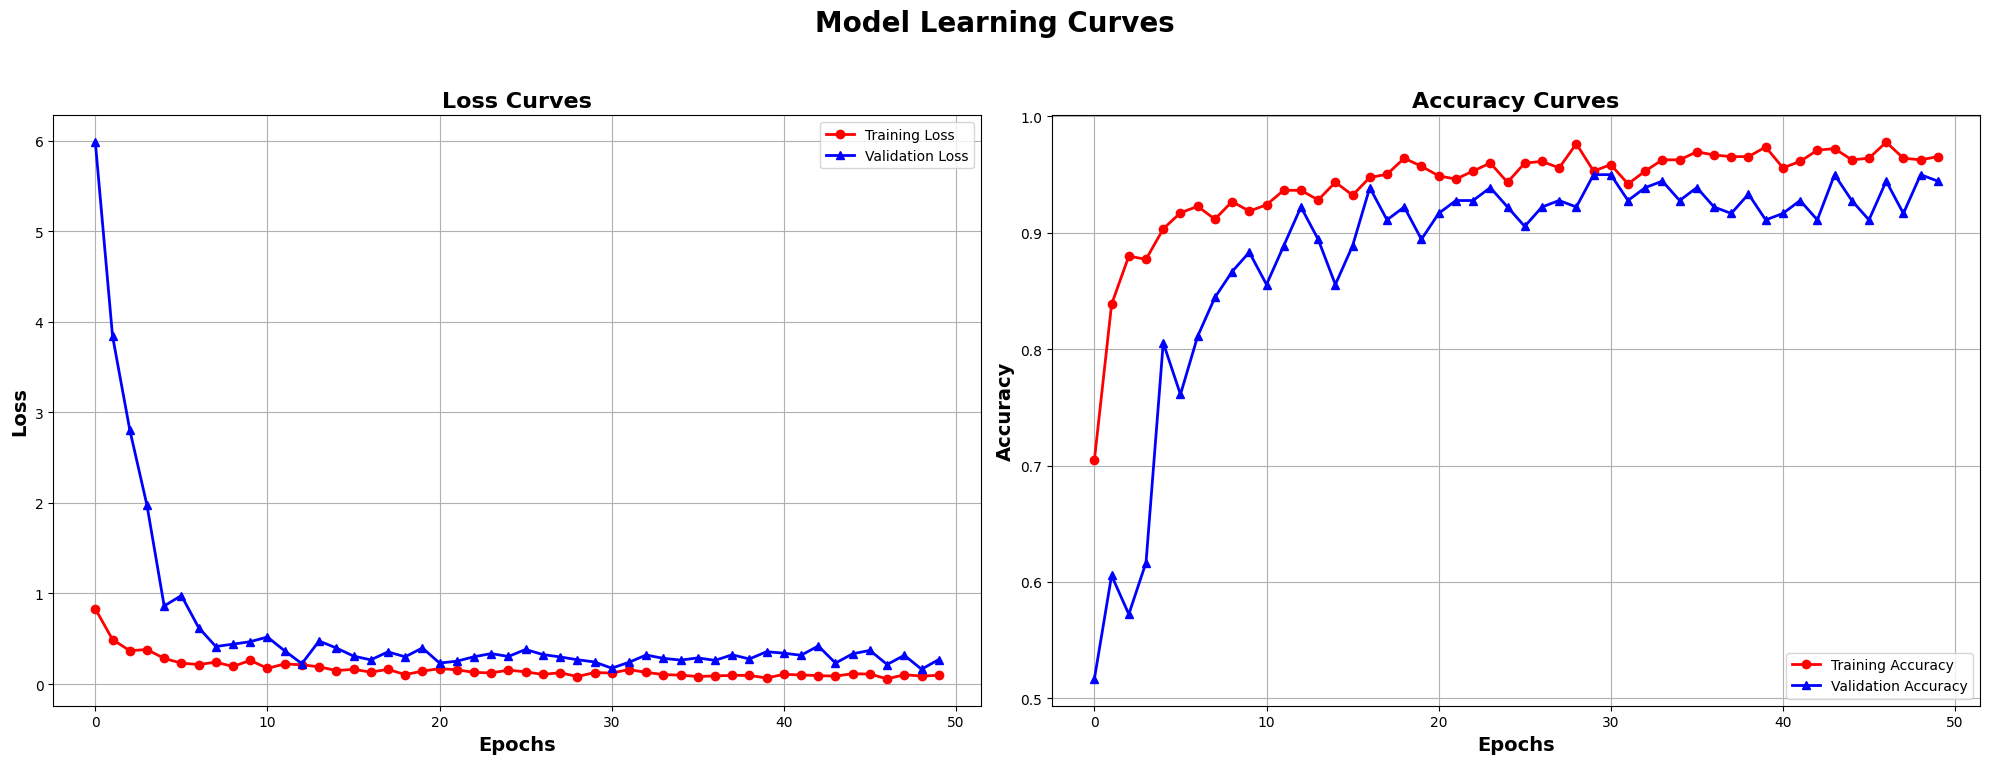

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function for plotting training curve
def plot_history(history):
    history_dict = history.history

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    # Vẽ độ mất mát
    ax[0].plot(history_dict["loss"], 'ro-', lw=2, markersize=6, label="Training Loss")
    ax[0].plot(history_dict["val_loss"], 'b^-', lw=2, markersize=6, label="Validation Loss")
    ax[0].set_title("Loss Curves", fontsize=16, weight='bold')
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel("Epochs", fontsize=14, weight='bold')
    ax[0].set_ylabel("Loss", fontsize=14, weight='bold')
    ax[0].grid(True)

    # Vẽ độ chính xác
    ax[1].plot(history_dict["accuracy"], 'ro-', lw=2, markersize=6, label="Training Accuracy")
    ax[1].plot(history_dict["val_accuracy"], 'b^-', lw=2, markersize=6, label="Validation Accuracy")
    ax[1].set_title("Accuracy Curves", fontsize=16, weight='bold')
    ax[1].legend(loc="lower right")
    ax[1].set_xlabel("Epochs", fontsize=14, weight='bold')
    ax[1].set_ylabel("Accuracy", fontsize=14, weight='bold')
    ax[1].grid(True)

    fig.suptitle("Model Learning Curves", fontsize=20, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Điều chỉnh khoảng cách giữa các biểu đồ
    plt.show()

# Vẽ biểu đồ cho quá trình huấn luyện
plot_history(history)

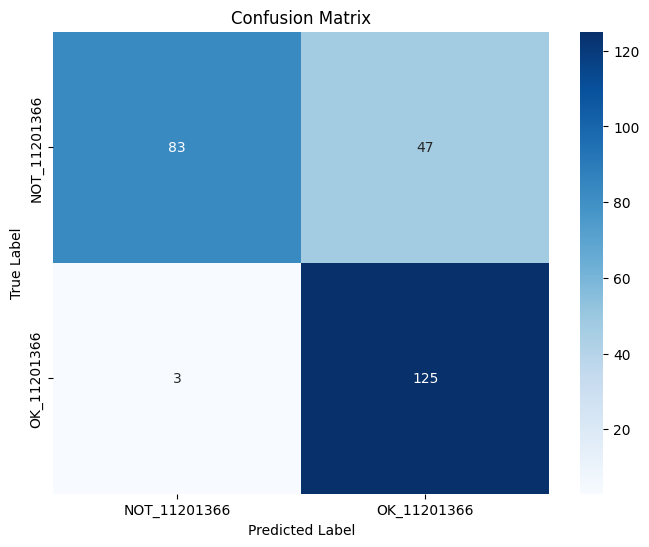

Confusion Matrix heatmap generated.


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix heatmap generated.")

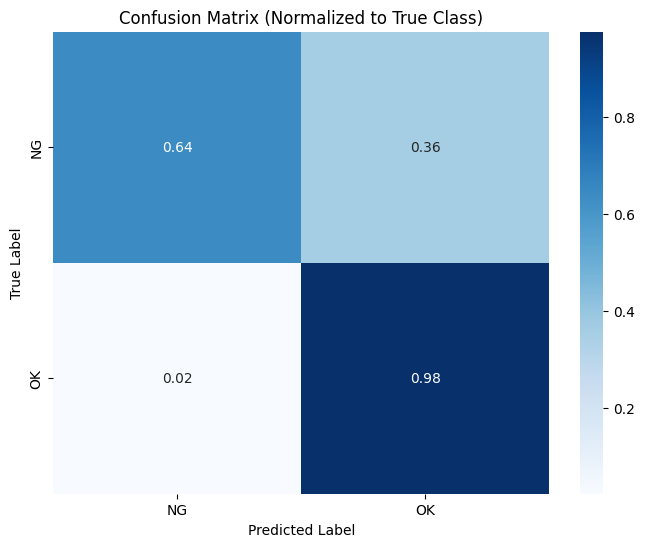

Confusion Matrix heatmap generated with decimal format and labels 'OK', 'NG'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Định nghĩa lại Tên Lớp
NEW_CLASS_NAMES = ['NG', 'OK']

# 2. CHUẨN HÓA MA TRẬN:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 3. Vẽ lại Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized,
            annot=True,                 # Hiển thị giá trị
            fmt='.2f',                  # Định dạng thập phân 2 chữ số
            cmap='Blues',               # Sử dụng màu Xanh
            xticklabels=NEW_CLASS_NAMES, # Nhãn trục X (Predicted)
            yticklabels=NEW_CLASS_NAMES) # Nhãn trục Y (True)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized to True Class)')
plt.show()

print("Confusion Matrix heatmap generated with decimal format and labels 'OK', 'NG'.")

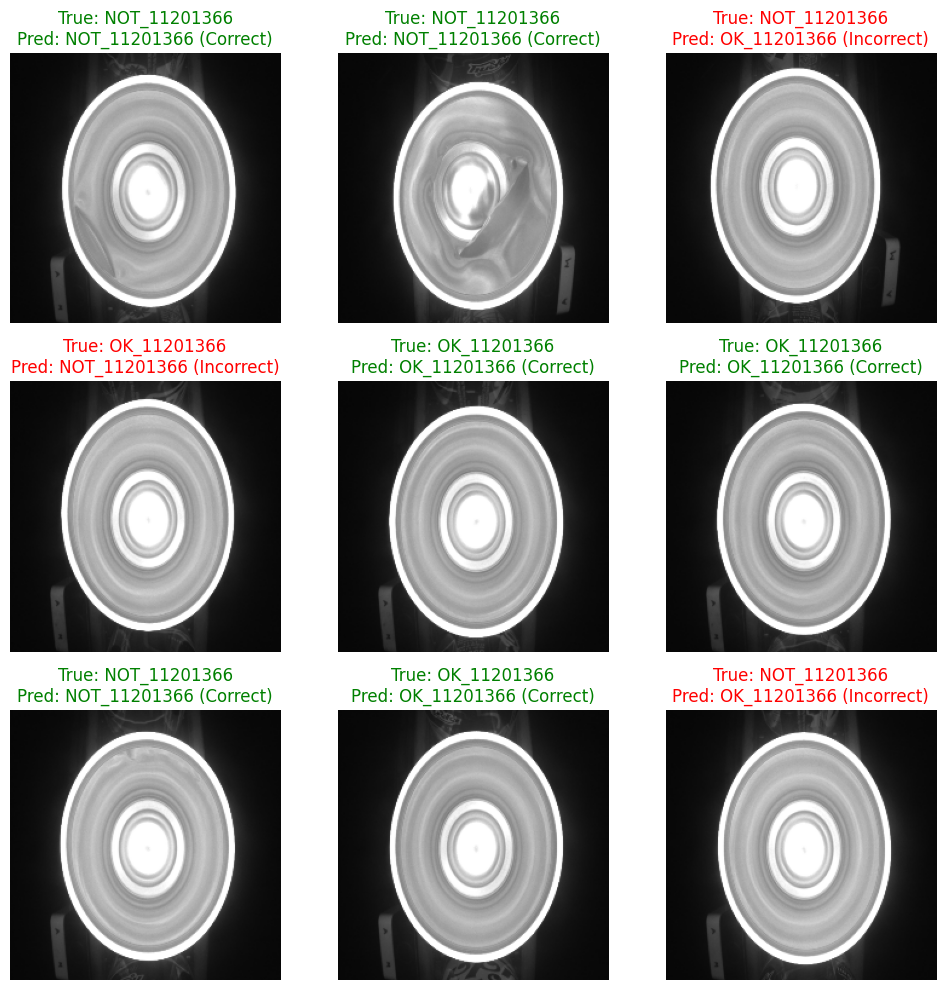

Example predictions with actual and predicted labels displayed.


In [ ]:
plt.figure(figsize=(10, 10))
num_examples_to_show = 9
example_count = 0

# Get true labels from test_ds for comparison with predicted_labels
true_labels_list = []
for _, labels in test_ds:
    true_labels_list.extend(labels.numpy())

# Counter for global index across all test samples
global_idx = 0

for images, true_labels_batch in test_ds:
    for i in range(images.shape[0]): # Iterate through images in the current batch
        if example_count >= num_examples_to_show:
            break

        # Denormalize image for display (assuming it was normalized to [0,1])
        image_display = (images[i].numpy() * 255).astype('uint8')

        # Get the true label for the current image from the batch
        true_label = true_labels_batch[i].numpy()

        # Get the predicted label for the current image from the pre-computed array
        # We use global_idx to correctly map the image to its prediction
        predicted_label = predicted_labels[global_idx][0]

        # Determine if the prediction was correct
        color = 'green' if predicted_label == true_label else 'red'
        status = 'Correct' if predicted_label == true_label else 'Incorrect'

        plt.subplot(3, 3, example_count + 1)
        plt.imshow(image_display)
        plt.title(f"True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[predicted_label]} ({status})", color=color)
        plt.axis('off')

        example_count += 1
        global_idx += 1 # Increment global index for next image

    if example_count >= num_examples_to_show:
        break

plt.tight_layout()
plt.show()

print("Example predictions with actual and predicted labels displayed.")

#**KIỂM THỬ**


> Tập dữ liệu kiểm thử (Test Set) bao gồm tổng cộng 1000 ảnh được phân bổ cân bằng (500 ảnh OK và 500 ảnh NG) và được chia thành hai nhóm chính để đảm bảo tính đại diện:




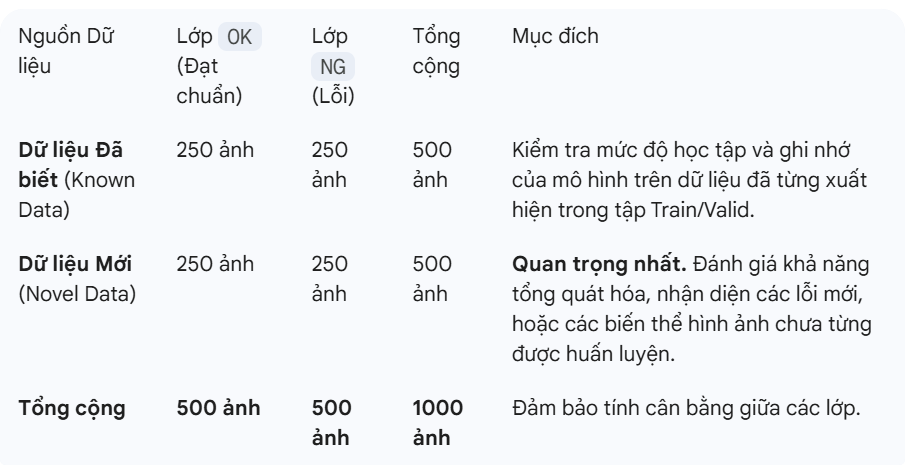

**2. Phương pháp Kiểm thử**

Sử dụng mô hình đã huấn luyện tốt nhất (best.pt) để chạy suy luận (Inference) trên toàn bộ 1000 ảnh của tập Kiểm thử này, sau đó đánh giá hiệu suất bằng các chỉ số sau, tập trung vào kết quả đầu ra cho mỗi ảnh:

* Độ chính xác Cấp độ Ảnh (Image-level Accuracy): Tính tỷ lệ phần trăm ảnh được phân loại đúng (True Class ID được phát hiện) trên tổng số ảnh trong tập Test.

**Công thức:**
$\frac{\text{Số ảnh dự đoán đúng lớp}}{\text{Tổng số ảnh cùng lớp}} \times 100\%$

In [ ]:
# Xác định đường dẫn đến file ZIP
zip_path = '/content/drive/MyDrive/DOANTOTNGHIEP/DATA_TEST.zip'

# Giải nén tập tin vào thư mục /content/dataset
!unzip -q {zip_path} -d /content/dataset

In [ ]:
import os

# List the contents of the data_dir_test directory recursively
print(f"Listing contents of {data_dir_test}:")
for root, dirs, files in os.walk(data_dir_test):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name) + '/')

print("Directory listing complete.")

Listing contents of /content/dataset/DATA_TEST:
/content/dataset/DATA_TEST/can_ng (1204).bmp
/content/dataset/DATA_TEST/can_ok-116-_bmp.rf.8fe91a654281cd5433b7ce275d256b07.jpg
/content/dataset/DATA_TEST/can_ok-211-_bmp.rf.3a384727dd3edba47a4c5080c6e88899.jpg
/content/dataset/DATA_TEST/can_ok-203-_bmp.rf.ed2b9a60409215d2dfb25b4a9527be28.jpg
/content/dataset/DATA_TEST/can_ng (1304).bmp
/content/dataset/DATA_TEST/can_ok (82).bmp
/content/dataset/DATA_TEST/can_ng (1230).bmp
/content/dataset/DATA_TEST/can_ng (1343).bmp
/content/dataset/DATA_TEST/can_ok-11-_bmp.rf.8694c6820f368653507a1134a1b6566a.jpg
/content/dataset/DATA_TEST/can_ok-104-_bmp.rf.fe4c78cacbb56928f10fed43b83afb90.jpg
/content/dataset/DATA_TEST/can_ng (1309).bmp
/content/dataset/DATA_TEST/can_ok (61).bmp
/content/dataset/DATA_TEST/can_ng-442-_bmp.rf.9afb35e0a11691081f250b702f63f364.jpg
/content/dataset/DATA_TEST/can_ok (249).bmp
/content/dataset/DATA_TEST/can_ok (6).bmp
/content/dataset/DATA_TEST/can_ok (171).bmp
/content/datas

In [ ]:
import os
import tensorflow as tf

# 1. Define the path to the new test data directory
data_dir_test = '/content/dataset/DATA_TEST'

# 2. Collect all image file paths using os.walk and filter by extension
image_paths_list = []
labels_list = []

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for root, _, files in os.walk(data_dir_test):
    for file in files:
        if file.lower().endswith(valid_extensions):
            img_path = os.path.join(root, file)
            filename = file.lower()
            label = -1

            if 'ok' in filename:
                label = 1  # 'OK' class
            elif 'ng' in filename:
                label = 0  # 'NG' class

            if label != -1: # Only add if a valid label was assigned
                image_paths_list.append(img_path)
                labels_list.append(label)

print(f"Found {len(image_paths_list)} images for new test dataset.")

# 5. Convert lists to TensorFlow tensors
image_paths_tensor = tf.constant(image_paths_list, dtype=tf.string) # Explicitly set dtype
labels_tensor = tf.constant(labels_list, dtype=tf.int32)

# 6. Create a tf.data.Dataset from these tensors
new_test_ds_raw = tf.data.Dataset.from_tensor_slices((image_paths_tensor, labels_tensor))

# 7. Define a parsing function to load, decode, resize, and preprocess images
def load_and_preprocess_image(image_path, label):
    # Read the image file
    img = tf.io.read_file(image_path)
    # Decode the image to RGB (3 channels)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize the image
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    # Apply the previously defined preprocess function (Rescaling to [0,1])
    img = preprocess_input(img)
    return img, label

# 8. Map the parsing function over the dataset
new_test_ds = new_test_ds_raw.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# 9. Batch, cache, and prefetch the dataset
new_test_ds = new_test_ds.batch(BATCH_SIZE)
new_test_ds = new_test_ds.cache()
new_test_ds = new_test_ds.prefetch(buffer_size=BUFFER_SIZE)

print("New test dataset prepared: batched, cached, and prefetched.")

Found 1000 images for new test dataset.
New test dataset prepared: batched, cached, and prefetched.


Evaluating model on new test dataset...

Overall Test Metrics (New Data):
Accuracy: 0.8200
Precision: 0.7649
Recall: 0.9240
F1-Score: 0.8370

Confusion Matrix (New Data):
[[358 142]
 [ 38 462]]


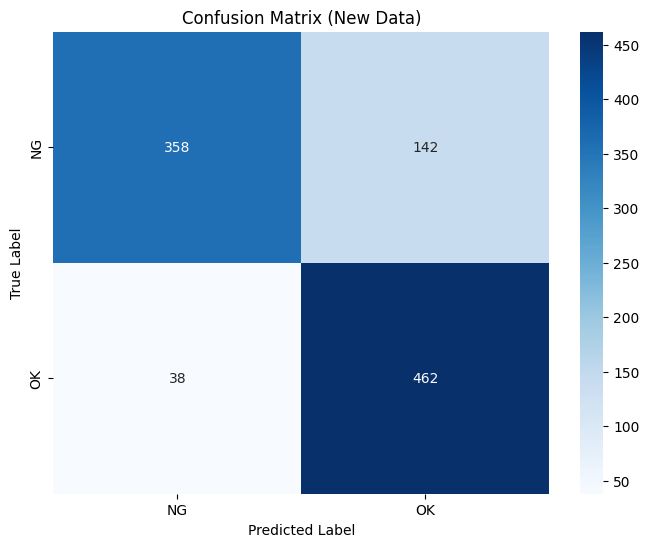


--- Evaluation Complete ---
Correct Predictions: {'NG': np.int64(358), 'OK': np.int64(462)}
Incorrect Predictions: {'NG': np.int64(38), 'OK': np.int64(142)}

Total images processed: 1000
Overall Accuracy: 82.00%

--- Detailed Accuracy Results ---
Accuracy for 'NG': 71.60%
Accuracy for 'OK': 92.40%
Overall Average Accuracy: 82.00%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Evaluating model on new test dataset...")

# 1. Extract the true labels from the new_test_ds
# We already have labels_list from the data preparation step
new_true_labels = np.array(labels_list)

# Ensure predicted_labels are flattened if they are a column vector
if new_predicted_labels.ndim > 1:
    new_predicted_labels = new_predicted_labels.flatten()

# 2. Calculate and print the test accuracy, precision, recall, and F1-score
overall_accuracy = accuracy_score(new_true_labels, new_predicted_labels)
precision = precision_score(new_true_labels, new_predicted_labels)
recall = recall_score(new_true_labels, new_predicted_labels)
f1 = f1_score(new_true_labels, new_predicted_labels)

print(f"\nOverall Test Metrics (New Data):")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 3. Calculate and print the confusion matrix
conf_matrix_new = confusion_matrix(new_true_labels, new_predicted_labels)
print("\nConfusion Matrix (New Data):")
print(conf_matrix_new)

# 4. Display confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_new,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=NEW_CLASS_NAMES,
            yticklabels=NEW_CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (New Data)')
plt.show()

# 5. Calculate correct and incorrect predictions per class
# True Negatives: true_label=0, predicted_label=0 (conf_matrix_new[0, 0])
# False Positives: true_label=0, predicted_label=1 (conf_matrix_new[0, 1])
# False Negatives: true_label=1, predicted_label=0 (conf_matrix_new[1, 0])
# True Positives: true_label=1, predicted_label=1 (conf_matrix_new[1, 1])

# Assuming NEW_CLASS_NAMES = ['NG', 'OK'] (0=NG, 1=OK)

correct_predictions = {NEW_CLASS_NAMES[0]: conf_matrix_new[0, 0], NEW_CLASS_NAMES[1]: conf_matrix_new[1, 1]}
incorrect_predictions = {NEW_CLASS_NAMES[0]: conf_matrix_new[1, 0], NEW_CLASS_NAMES[1]: conf_matrix_new[0, 1]}

total_correct = sum(correct_predictions.values())
total_incorrect = sum(incorrect_predictions.values())
total_images_processed = total_correct + total_incorrect # Should be len(new_true_labels)

overall_accuracy_percentage = (total_correct / total_images_processed) * 100 if total_images_processed > 0 else 0

print(f"\n--- Evaluation Complete ---")
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")
print(f"\nTotal images processed: {total_images_processed}")
print(f"Overall Accuracy: {overall_accuracy_percentage:.2f}%")

# Calculate and print detailed accuracy per class
accuracy_ng = (conf_matrix_new[0, 0] / (conf_matrix_new[0, 0] + conf_matrix_new[0, 1])) * 100 if (conf_matrix_new[0, 0] + conf_matrix_new[0, 1]) > 0 else 0
accuracy_ok = (conf_matrix_new[1, 1] / (conf_matrix_new[1, 0] + conf_matrix_new[1, 1])) * 100 if (conf_matrix_new[1, 0] + conf_matrix_new[1, 1]) > 0 else 0

print(f"\n--- Detailed Accuracy Results ---")
print(f"Accuracy for '{NEW_CLASS_NAMES[0]}': {accuracy_ng:.2f}%")
print(f"Accuracy for '{NEW_CLASS_NAMES[1]}': {accuracy_ok:.2f}%")
print(f"Overall Average Accuracy: {overall_accuracy_percentage:.2f}%")

###**Lưu và tải mô hình**
---
Tải các trọng số mô hình đã lưu tốt nhất (`best_efficientnet_model.weights.h5`) để đảm bảo chúng ta đang sử dụng mô hình đã được tinh chỉnh. Sử dụng mô hình này để tạo dự đoán (xác suất) trên `new_test_ds` vừa được chuẩn bị. Chuyển đổi các xác suất dự đoán này thành nhãn lớp nhị phân (0 hoặc 1) bằng cách sử dụng ngưỡng 0,5.

In [ ]:
print("Loading best model weights...")
model.load_weights('best_efficientnet_model.weights.h5')
print("Best model weights loaded.")

print("Making predictions on new test dataset...")
new_predictions = model.predict(new_test_ds)

print("Converting predictions to binary labels...")
new_predicted_labels = (new_predictions > 0.5).astype(int)

print("Predictions generated and converted to binary labels.")

Loading best model weights...
Best model weights loaded.
Making predictions on new test dataset...
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step
Converting predictions to binary labels...
Predictions generated and converted to binary labels.


##**Kết quả dự đoán**

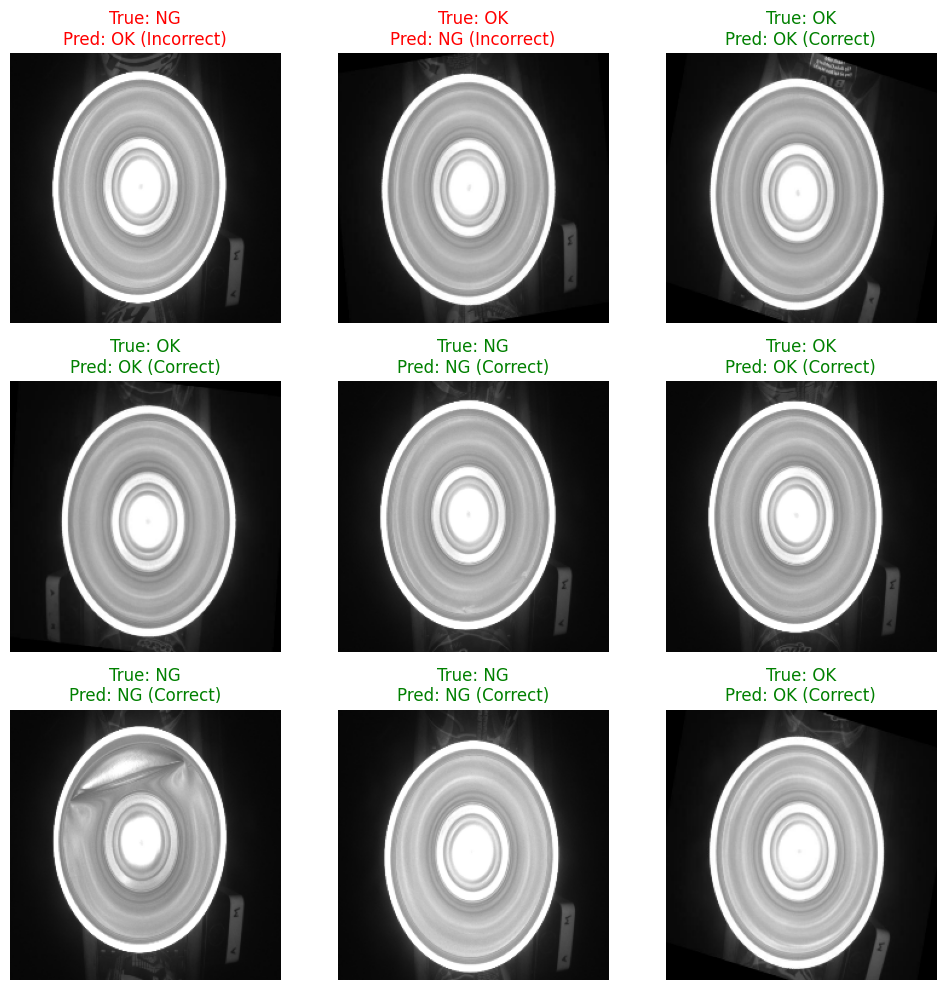

Example predictions with actual and predicted labels from new test dataset displayed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
num_examples_to_show = 9 # Display 9 example predictions
example_count = 0

# Ensure NEW_CLASS_NAMES is defined, e.g., NEW_CLASS_NAMES = ['NG', 'OK']
# Ensure new_predicted_labels (flattened) and labels_list (new_true_labels) are available from previous steps

# Counter for global index across all samples in new_test_ds
global_idx = 0

for images, true_labels_batch in new_test_ds:
    for i in range(images.shape[0]): # Iterate through images in the current batch
        if example_count >= num_examples_to_show:
            break

        # Denormalize image for display (assuming it was normalized to [0,1])
        image_display = (images[i].numpy() * 255).astype('uint8')

        # Get the true label for the current image from the batch
        true_label = true_labels_batch[i].numpy()

        # Get the predicted label for the current image from the pre-computed new_predicted_labels array
        # We use global_idx to correctly map the image to its prediction
        predicted_label = new_predicted_labels[global_idx]

        # Determine if the prediction was correct
        color = 'green' if predicted_label == true_label else 'red'
        status = 'Correct' if predicted_label == true_label else 'Incorrect'

        plt.subplot(3, 3, example_count + 1) # Create a 3x3 grid for display
        plt.imshow(image_display)
        plt.title(f"True: {NEW_CLASS_NAMES[true_label]}\nPred: {NEW_CLASS_NAMES[predicted_label]} ({status})", color=color)
        plt.axis('off')

        example_count += 1
        global_idx += 1 # Increment global index for next image

    if example_count >= num_examples_to_show:
        break

plt.tight_layout()
plt.show()

print("Example predictions with actual and predicted labels from new test dataset displayed.")

###**Tải ảnh lên dự đoán**

Vui lòng tải lên một tệp ảnh để dự đoán.


Saving can_ng (5).bmp to can_ng (5) (2).bmp
Đã tải lên tệp: can_ng (5) (2).bmp
Đang thực hiện dự đoán...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted probability: 0.1704
Predicted class: NG


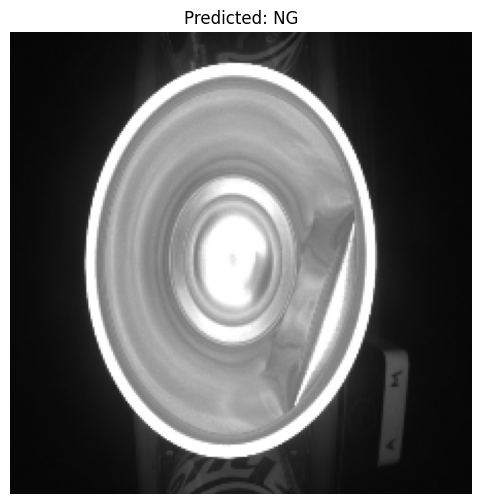

Dự đoán hoàn tất cho ảnh đã tải lên.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files # Import files module for upload

print("Vui lòng tải lên một tệp ảnh để dự đoán.")

# Upload file from local machine
uploaded = files.upload()

# Assuming only one file is uploaded for simplicity
for filename in uploaded.keys():
    print(f"Đã tải lên tệp: {filename}")
    image_bytes_data = uploaded[filename]

    # Hàm tải và tiền xử lý ảnh từ dữ liệu byte
    def load_and_preprocess_single_image_from_bytes(image_bytes):
        img = tf.io.decode_image(image_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        img = preprocess_input(img) # Sử dụng hàm preprocess_input đã định nghĩa trước đó
        return img

    # Tiền xử lý ảnh
    processed_image = load_and_preprocess_single_image_from_bytes(image_bytes_data)

    # Thêm một chiều batch (mô hình mong đợi đầu vào theo lô)
    input_image_for_prediction = tf.expand_dims(processed_image, axis=0)

    print("Đang thực hiện dự đoán...")

    # Thực hiện dự đoán
    prediction = model.predict(input_image_for_prediction)

    # Chuyển đổi xác suất thành nhãn nhị phân (0 hoặc 1)
    predicted_label_index = (prediction > 0.5).astype(int)[0][0]
    predicted_class_name = NEW_CLASS_NAMES[predicted_label_index]

    print(f"Predicted probability: {prediction[0][0]:.4f}")
    print(f"Predicted class: {predicted_class_name}")

    # Hiển thị ảnh và kết quả dự đoán
    plt.figure(figsize=(6, 6))
    plt.imshow((processed_image.numpy() * 255).astype('uint8')) # Denormalize for display
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

print("Dự đoán hoàn tất cho ảnh đã tải lên.")

Please upload an image file for prediction.


Saving can_ng (40).bmp to can_ng (40).bmp
Uploaded file: can_ng (40).bmp
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted probability: 0.6774
Predicted class: OK


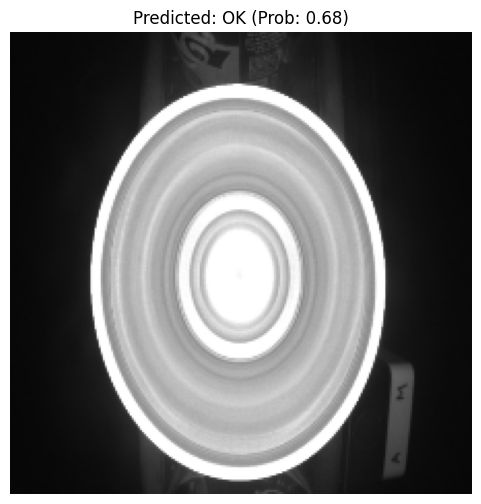

Prediction complete for uploaded image.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files # Import files module for upload
import io

print("Please upload an image file for prediction.")

# Upload file from local machine
uploaded = files.upload()

# Assuming only one file is uploaded
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")
    image_data = uploaded[filename]

    # Hàm tải và tiền xử lý ảnh cho dự đoán từ dữ liệu byte
    def load_and_preprocess_single_image_from_bytes(image_bytes):
        img = tf.io.decode_image(image_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        img = preprocess_input(img) # Sử dụng hàm preprocess_input đã định nghĩa trước đó
        return img

    # Tiền xử lý ảnh
    processed_image = load_and_preprocess_single_image_from_bytes(image_data)

    # Thêm một chiều batch (mô hình mong đợi đầu vào theo lô)
    input_image_for_prediction = tf.expand_dims(processed_image, axis=0)

    print("Making prediction...")

    # Thực hiện dự đoán
    prediction = model.predict(input_image_for_prediction)

    # Chuyển đổi xác suất thành nhãn nhị phân (0 hoặc 1)
    predicted_label_index = (prediction > 0.5).astype(int)[0][0]
    predicted_class_name = NEW_CLASS_NAMES[predicted_label_index]

    print(f"Predicted probability: {prediction[0][0]:.4f}")
    print(f"Predicted class: {predicted_class_name}")

    # Hiển thị ảnh và kết quả dự đoán
    plt.figure(figsize=(6, 6))
    plt.imshow((processed_image.numpy() * 255).astype('uint8')) # Denormalize for display
    plt.title(f"Predicted: {predicted_class_name} (Prob: {prediction[0][0]:.2f})")
    plt.axis('off')
    plt.show()

print("Prediction complete for uploaded image.")
